## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Находнов Максим Сергеевич

In [1]:
import math

import numpy as np

from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision import transforms

import train_utils

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

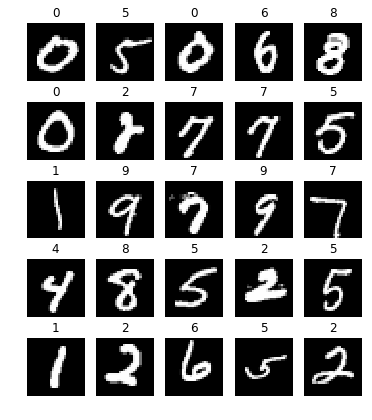

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [6]:
def init_layer_normal(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=mean, std=std)
    
def init_layer_uniform(layer, from_=0, to=1):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.uniform_(from_, to)

def forward_hook(self, input_, output):
    std = input_[0].std().data[0]
    print 'forward', std

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().data[0]
    print 'backward', std

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer_normal(layer, 0.0, 0.1) # сюда надо подставить другие параметры

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [7]:
def new_linear_layer(input_size, output_size, way=None, mean=0, std=1):
    layer = nn.Linear(input_size, output_size)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    if way == None:
        init_layer_normal(layer, mean, std)
    elif way == 'Xavier_Normal':
        init_layer_normal(layer, 0, math.sqrt(2./(input_size + output_size)))
    elif way == 'Xavier_Uniform':
        init_layer_uniform(layer, -math.sqrt(6./(input_size + output_size)), math.sqrt(6./(input_size + output_size)))
    elif way == 'He':
        init_layer_normal(layer, 0, math.sqrt(2./(input_size)))
                           
    return layer

In [8]:
# Normal M(0, 0.1)
layers = []
mean = 0
std = 0.1
layers.append(new_linear_layer(784, 500, mean=mean, std=std))
layers.append(nn.ReLU())
for i in range(10):
    layers.append(new_linear_layer(500, 500, mean=mean, std=std))
    layers.append(nn.ReLU())
layers.append(new_linear_layer(500, 10, mean=mean, std=std))
layers.append(nn.LogSoftmax())

network = nn.Sequential(*layers).cuda()
loss_fn = torch.nn.NLLLoss().cuda()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 

n_objects = 100

X = Variable(images_train[:n_objects]).cuda().view(n_objects, -1)
y = Variable(labels_train[:n_objects]).cuda()

network.zero_grad()
activations = network(X)
loss = loss_fn(activations, y)
loss.backward()

forward 1.01831865311
forward 1.70663940907
forward 2.76577353477
forward 4.46514511108
forward 7.24643754959
forward 11.4583921432
forward 18.8234081268
forward 30.1237506866
forward 47.8837432861
forward 76.6162719727
forward 118.45199585
forward 190.804016113
backward 0.00417313165963
backward 0.000921120401472
backward 0.00140161428135
backward 0.00228998996317
backward 0.00370086031035
backward 0.00586119480431
backward 0.00933307502419
backward 0.0149954659864
backward 0.0234853159636
backward 0.0370646081865
backward 0.0586848892272
backward 0.0939439311624


/home/m.nakhodnov/anaconda3/envs/py2.7.14/lib/python2.7/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [9]:
# Xavier Normal
layers = []
layers.append(new_linear_layer(784, 500, 'Xavier_Normal'))
layers.append(nn.Tanh())
for i in range(10):
    layers.append(new_linear_layer(500, 500, 'Xavier_Normal'))
    layers.append(nn.Tanh())
layers.append(new_linear_layer(500, 10, 'Xavier_Normal'))
layers.append(nn.LogSoftmax())

network = nn.Sequential(*layers).cuda()
loss_fn = torch.nn.NLLLoss().cuda()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 

n_objects = 100

X = Variable(images_train[:n_objects]).cuda().view(n_objects, -1)
y = Variable(labels_train[:n_objects]).cuda()

network.zero_grad()
activations = network(X)
loss = loss_fn(activations, y)
loss.backward()

forward 1.01831865311
forward 0.657461285591
forward 0.507525026798
forward 0.420630663633
forward 0.363845944405
forward 0.323791563511
forward 0.295427292585
forward 0.272172421217
forward 0.253558665514
forward 0.236447766423
forward 0.223046317697
forward 0.213598325849
backward 0.00303545501083
backward 0.0005669236416
backward 0.000537794898264
backward 0.000509144098032
backward 0.000476025103126
backward 0.0004431764537
backward 0.000402044184739
backward 0.000358012039214
backward 0.00031811799272
backward 0.000267420953605
backward 0.000211314487387
backward 0.000138997056638


In [10]:
# Xavier Uniform
layers = []
layers.append(new_linear_layer(784, 500, 'Xavier_Uniform'))
layers.append(nn.Tanh())
for i in range(10):
    layers.append(new_linear_layer(500, 500, 'Xavier_Uniform'))
    layers.append(nn.Tanh())
layers.append(new_linear_layer(500, 10, 'Xavier_Uniform'))
layers.append(nn.LogSoftmax())

network = nn.Sequential(*layers).cuda()
loss_fn = torch.nn.NLLLoss().cuda()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 

n_objects = 100

X = Variable(images_train[:n_objects]).cuda().view(n_objects, -1)
y = Variable(labels_train[:n_objects]).cuda()

network.zero_grad()
activations = network(X)
loss = loss_fn(activations, y)
loss.backward()

forward 1.01831865311
forward 0.6581133008
forward 0.500495791435
forward 0.415801018476
forward 0.360667318106
forward 0.324834138155
forward 0.296485424042
forward 0.268887788057
forward 0.251037359238
forward 0.23846141994
forward 0.228757977486
forward 0.221766710281
backward 0.00301770959049
backward 0.000566871254705
backward 0.000539968605153
backward 0.000504090974573
backward 0.000472936691949
backward 0.000432943576016
backward 0.0003952056868
backward 0.000356131233275
backward 0.0003144464863
backward 0.000268098170636
backward 0.000209679128602
backward 0.000137431648909


In [11]:
# He
layers = []
layers.append(new_linear_layer(784, 500, 'He'))
layers.append(nn.ReLU())
for i in range(10):
    layers.append(new_linear_layer(500, 500, 'He'))
    layers.append(nn.ReLU())
layers.append(new_linear_layer(500, 10, 'He'))
layers.append(nn.LogSoftmax())

network = nn.Sequential(*layers).cuda()
loss_fn = torch.nn.NLLLoss().cuda()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 

n_objects = 100

X = Variable(images_train[:n_objects]).cuda().view(n_objects, -1)
y = Variable(labels_train[:n_objects]).cuda()

network.zero_grad()
activations = network(X)
loss = loss_fn(activations, y)
loss.backward()

forward 1.01831865311
forward 0.844116687775
forward 0.860984921455
forward 0.866399228573
forward 0.838776171207
forward 0.881441414356
forward 0.894464433193
forward 0.920919895172
forward 0.88402235508
forward 0.907397568226
forward 0.870596766472
forward 0.870190799236
backward 0.00325009739026
backward 0.000472837360576
backward 0.000471934617963
backward 0.000472985761007
backward 0.000477534689708
backward 0.000467510690214
backward 0.000482635892695
backward 0.000502359180246
backward 0.000506088661496
backward 0.000497600238305
backward 0.000503653893247
backward 0.000505097035784


<i> 1.4 Сделайте выводы по первой части </i>

При инициализации из нормального распределения, распределения выходов активаций значительно меняются при переходе к более глубоким слоям. Инициализация же с помощью Xavier (для Tanh) и He (для ReLU) делает распределения активаций более-менее одинаковым от слоя к слою. (При этом, для Xavier, нет разницы семплировать ли из нормального или из равномерного распределения с той же дисперсией)  

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [26]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5, mean=0, std=0.01):
        super(DropConnect, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim).normal_(mean=mean, std=std), requires_grad=True)
        self.bias = nn.Parameter(torch.Tensor(1, output_dim).zero_(), requires_grad=True)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.zeros(self.weight.size()) + (1 - self.p)
            mask = torch.bernoulli(mask)
        else:
            mask = torch.ones(self.weight.size()) * self.p
        mask = Variable(mask, requires_grad=False)
        if torch.cuda.is_available:
            mask = mask.cuda()
        output = torch.mm(x, self.weight * mask) + self.bias
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

Epoch 19... (Train/Test) NLL: 0.011/0.113	Accuracy: 0.996/0.980

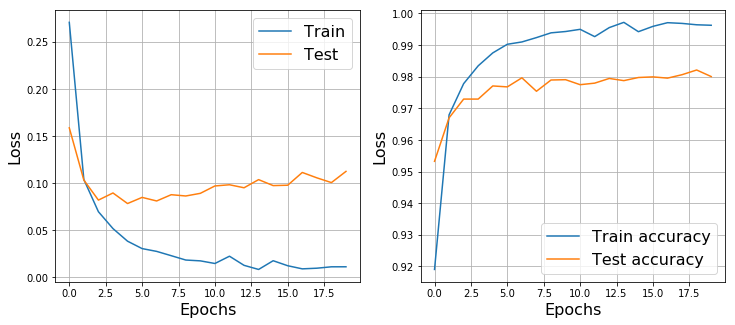

In [23]:
torch.cuda.set_device(2)
network = nn.Sequential(nn.Linear(784, 200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax()).cuda()

train_utils.train(network, train_loader, test_loader, 20, 0.001, ravel_init=True)

Epoch 19... (Train/Test) NLL: 0.097/0.072	Accuracy: 0.970/0.978

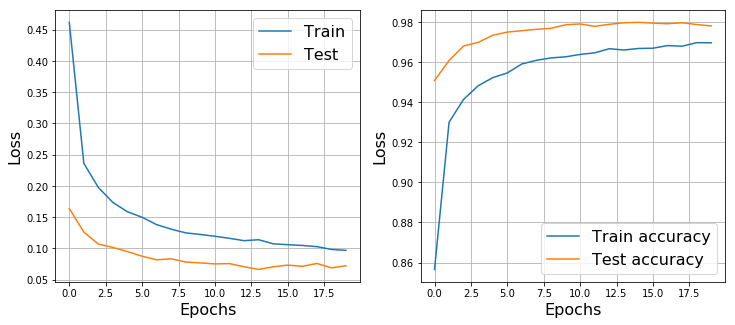

In [25]:
network = nn.Sequential(nn.Linear(784, 200),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax()).cuda()

train_utils.train(network, train_loader, test_loader, 20, 0.001, ravel_init=True)

Epoch 19... (Train/Test) NLL: 0.058/0.070	Accuracy: 0.980/0.979

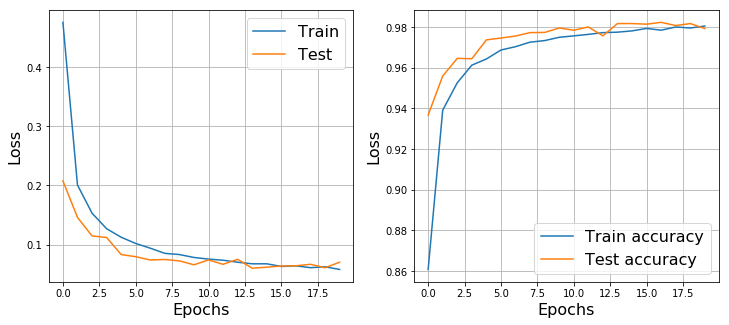

In [27]:
network = nn.Sequential(DropConnect(784, 200, p=0.5),
                        nn.ReLU(),
                        DropConnect(200, 200, p=0.5),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax()).cuda()

train_utils.train(network, train_loader, test_loader, 20, 0.001, ravel_init=True)

<i> 2.3 Сделайте выводы по третьей части </i>

И Dropout, и Dropconnect позволяют справляться с проблемой переобучения, однако, на точность предсказаний эти модули почти ни как не влияют

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [29]:
# полезные функции: .std(dim), .mean(dim)
class LayerNormalization(nn.Module):
    def __init__(self, input_dim):
        super(LayerNormalization, self).__init__()
        self.gamma = nn.Parameter(torch.cuda.FloatTensor(input_dim).fill_(1.0), requires_grad=True)
        self.delta = nn.Parameter(torch.cuda.FloatTensor(input_dim).fill_(0.01), requires_grad=True)
        
    def forward(self, x):
        output = self.gamma * (x - torch.mean(x, 1, True)) / torch.std(x, 1, True) + self.delta
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

Epoch 19... (Train/Test) NLL: 0.007/0.085	Accuracy: 0.997/0.980

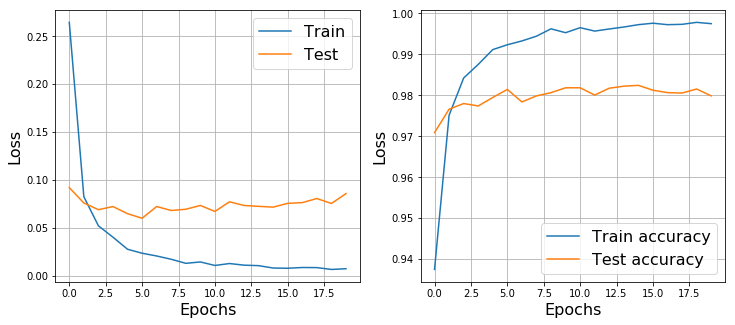

In [32]:
network = nn.Sequential(nn.Linear(784, 200),
                        nn.BatchNorm1d(200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.BatchNorm1d(200),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax()).cuda()

train_utils.train(network, train_loader, test_loader, 20, 0.001, ravel_init=True)

Epoch 19... (Train/Test) NLL: 0.005/0.084	Accuracy: 0.999/0.980

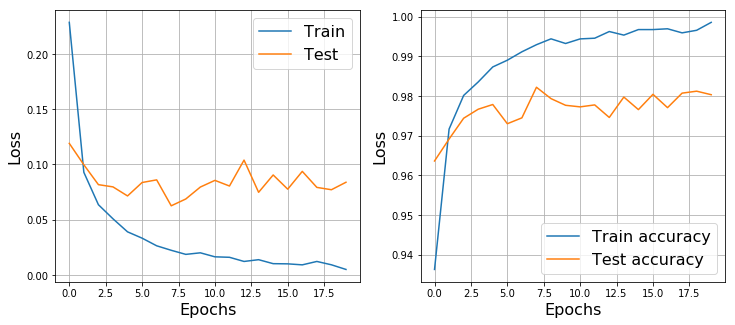

In [34]:
network = nn.Sequential(nn.Linear(784, 200),
                        LayerNormalization(200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        LayerNormalization(200),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax()).cuda()

train_utils.train(network, train_loader, test_loader, 20, 0.001, ravel_init=True)

<i> 3.3 Сделайте выводы по третьей части </i>

Ни BatchNorm, ни LayerNormalization не позваляют справиться с проблемой переобучения. При этом улучшения в качестве по сравнению с архитектурой без нормальзации так же не наблюдается.  

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: